# The quintic Ornstein-Uhlenbeck volatility model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import ImpliedDrift as iD
import time
import Quintic

from scipy.optimize import least_squares as ls
from matplotlib import cm

In [2]:
spot = np.array(pd.read_csv("spot.csv").Spot)
S0 = spot[0]

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100

## SPX options by Monte Carlo with antithetic and control variates

In [3]:
start_time = time.time()

nr = len(maturities); nc = len(K); model_vol = np.zeros([nr,nc]);
inp = np.array([-0.65, 0.2, 0.02, 1, 0.01, 0.02, 0.05]) # Parameter array [rho, H, eps, a0, a1, a3, a5]
bnds = ([-0.999, -0.1, 1e-10, 0, 0, 0, 0],[-1e-9, 0.5, 0.5, np.inf, np.inf, np.inf, np.inf])
N = 12500; n = 3650;
T = maturities[-1];
steps = np.ceil(n*maturities/T).astype(int)
option_type = np.ones(nc)

index = 0; np.random.seed(index);
w = np.concatenate((np.zeros([1,N*2]), Quintic.dW(n, N)))
    
def h(x):
    
    t = time.time()
    
    np.random.seed(0)
    iv = np.zeros([nr,nc])
        
    rho, H, eps, a0, a1, a3, a5 = x
    a_k = np.array([a0, a1, a3, a5])

    P = Quintic.global_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, steps, maturities, index)
    
    for i in range(nr):
        T_aux = maturities[i]
        r = iD.r(T_aux, index); q = iD.q(T_aux, index);
        iv[i,:] = bs.BSImpliedVol(S0, K, T_aux, r, q, P[i], Option_type = 1, toll = 1e-5)
    
    print(f'Function execution time: {time.time()-t: .2f}s')

    return iv

def f(x):
    return h(x).flatten() - IV.flatten()

result = ls(f, inp, bounds = bnds, max_nfev = 10, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
model_param = result.x
    
model_vol = h(result.x)

print(f'\nTotal execution time: {(time.time() - start_time)/60: .2f} minutes\n')

print(f'Mean relative error: {np.mean(np.abs((model_vol-IV)/IV))*100: .4f}%')

Function execution time:  46.46s
Function execution time:  54.43s
Function execution time:  44.49s
Function execution time:  43.53s
Function execution time:  41.81s
Function execution time:  33.70s
Function execution time:  41.60s
Function execution time:  38.94s
Function execution time:  37.82s
Function execution time:  37.08s
Function execution time:  39.57s
Function execution time:  36.62s
Function execution time:  35.71s
Function execution time:  30.70s
Function execution time:  38.98s
Function execution time:  34.34s
Function execution time:  41.80s
Function execution time:  36.06s
Function execution time:  39.99s
Function execution time:  38.91s
Function execution time:  37.66s
Function execution time:  39.37s
Function execution time:  41.60s
Function execution time:  38.49s
Function execution time:  36.78s
Function execution time:  40.82s
Function execution time:  43.87s
Function execution time:  34.62s
Function execution time:  39.87s
Function execution time:  36.28s
Function e

In [4]:
model_param

array([-0.93924304,  0.10678871,  0.03377894,  0.94018034,  0.26250973,
        0.06481121,  0.16323247])

In [5]:
df = pd.DataFrame(model_param.reshape([1,7]), columns = ["rho", "H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("quintic_parameters2.csv", index = False)

In [6]:
db = pd.DataFrame(model_vol)
db.to_csv("quintic_iv2.csv", index = False)

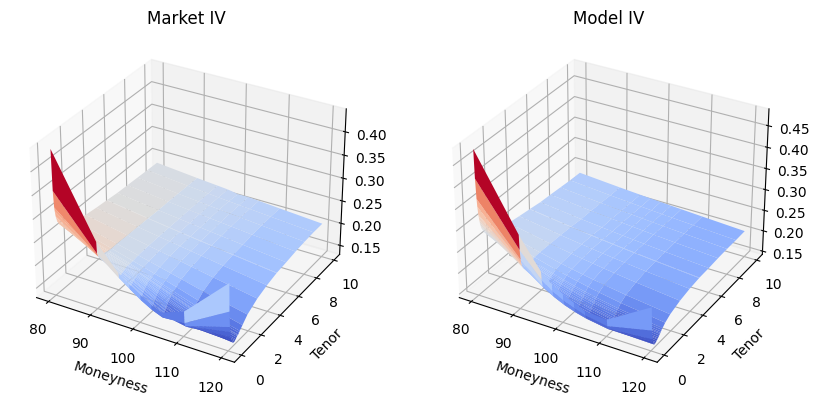

In [7]:
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, model_vol, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
#ax2.set_zlabel('IV Calibrated')
ax2.set_title('Model IV')

plt.show()